In [1]:
import os
import cv2
import random
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
    print("CUDA(GPU)를 사용합니다.")
else:
    device = torch.device('cpu')
    print("CUDA(GPU)를 사용할 수 없으므로,  CPU를 사용합니다.")

CUDA(GPU)를 사용합니다.


---

# Data Load

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/

!unzip -qq "/content/drive/MyDrive/Face_Mask_Dataset.zip"

/content/drive/MyDrive
replace Face Mask Dataset/Test/WithMask/1163.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [37]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()])

# 데이터셋 로드 시 변환 적용
train_set = datasets.ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Train', transform=transform)

# 수정된 DataLoader 생성
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)

In [24]:
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)  # 배치 크기
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [ ]:
calculate_mean_std(train_loader)

# Preprocessing Data

In [38]:
# 데이터셋을 불러오는 함수 정의
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5685, 0.4648, 0.4162], [0.2430, 0.2229, 0.2187])
])

# 데이터셋을 불러옵니다.
train_set = datasets.ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Train', transform=transform)
test_set = datasets.ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Test', transform=transform)
val_set = datasets.ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Validation', transform=transform)

In [39]:
# 데이터로더를 생성합니다.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)

In [ ]:
next(iter(train_loader))[0].shape

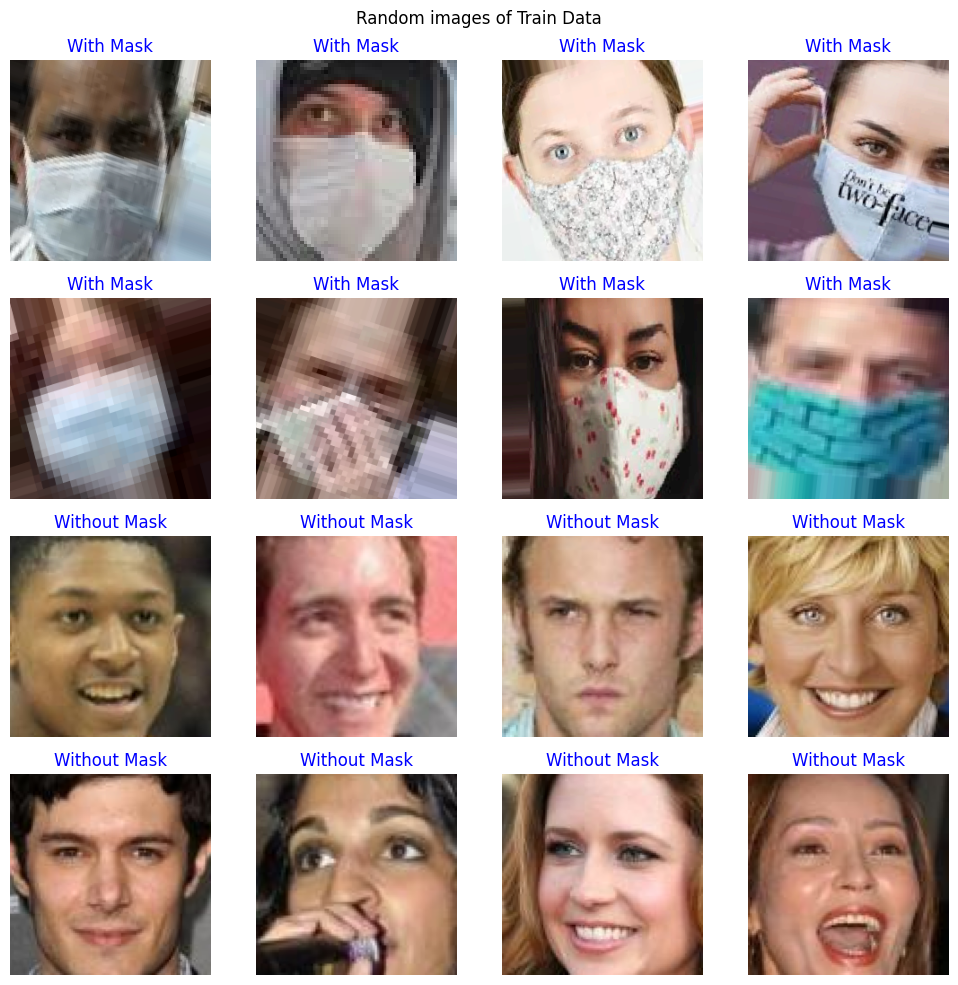

In [9]:
with_mask_path = "/content/drive/MyDrive/Face Mask Dataset/Train/WithMask"
without_mask_path = "/content/drive/MyDrive/Face Mask Dataset/Train/WithoutMask"

def sample_images(directory, num_samples):
    images = [os.path.join(directory, file) for file in os.listdir(directory)]
    return random.sample(images, min(num_samples, len(images)))

with_mask_img_paths = sample_images(with_mask_path, 8)
without_mask_img_paths = sample_images(without_mask_path, 8)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, img_path in enumerate(with_mask_img_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    axes[i//4, i%4].imshow(img)
    axes[i//4, i%4].set_title("With Mask",color= 'blue')
    axes[i//4, i%4].axis('off')

for i, img_path in enumerate(without_mask_img_paths):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    axes[2+i//4, i%4].imshow(img)
    axes[2+i//4, i%4].set_title("Without Mask",color='blue')
    axes[2+i//4, i%4].axis('off')

plt.suptitle('Random images of Train Data')
plt.tight_layout()
plt.show()

# Dataset Distribution

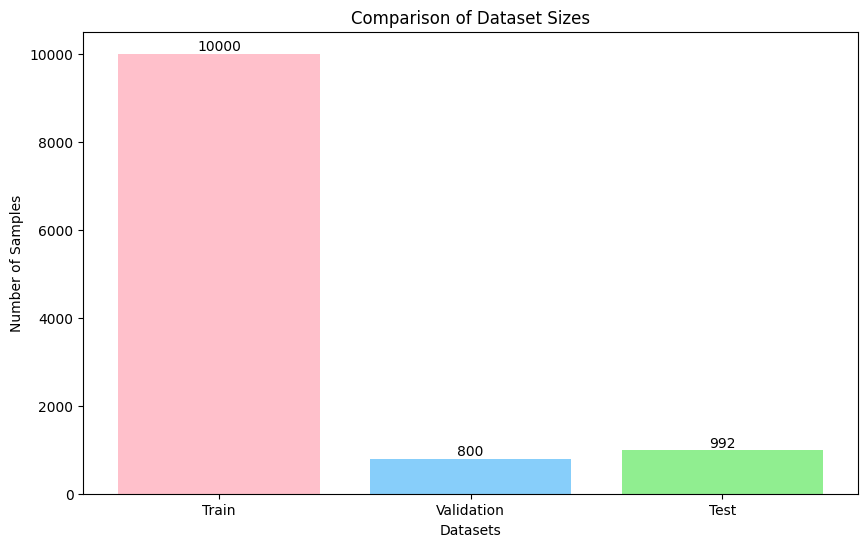

In [167]:
train_size = len(train_set)
valid_size = len(val_set)
test_size = len(test_set)

datasets = ['Train', 'Validation', 'Test']

sizes = [train_size, valid_size, test_size]

colors = ['#FFC0CB', '#87CEFA', '#90EE90']

plt.figure(figsize=(10, 6))
bars = plt.bar(datasets, sizes, color=colors)

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())),
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Datasets')
plt.ylabel('Number of Samples')
plt.title('Comparison of Dataset Sizes')
plt.show()

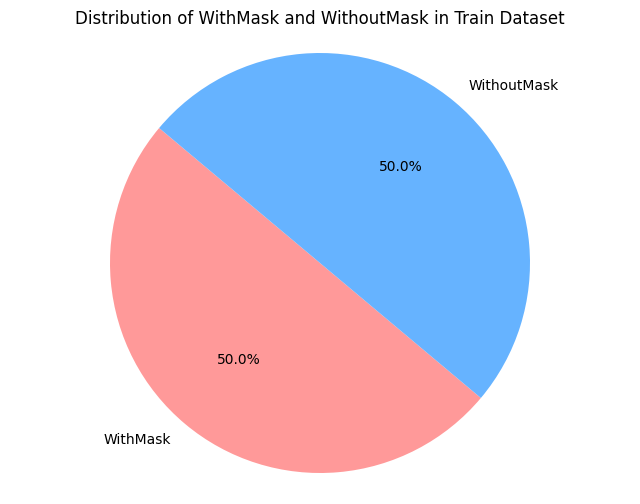

In [10]:
with_mask_dir = '/content/drive/MyDrive/Face Mask Dataset/Train/WithMask'
without_mask_dir = '/content/drive/MyDrive/Face Mask Dataset/Train/WithoutMask'

num_with_mask = len(os.listdir(with_mask_dir))
num_without_mask = len(os.listdir(without_mask_dir))

colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(8, 6), facecolor='white')
plt.pie([num_with_mask, num_without_mask], labels=['WithMask', 'WithoutMask'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of WithMask and WithoutMask in Train Dataset')
plt.axis('equal')  

plt.show()

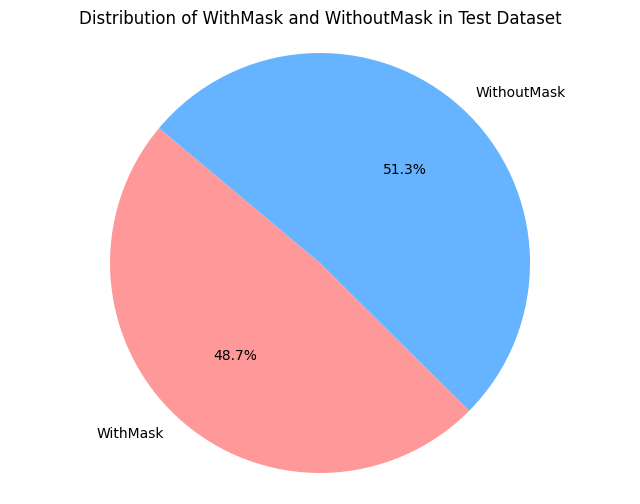

In [11]:
with_mask_dir = '/content/drive/MyDrive/Face Mask Dataset/Test/WithMask'
without_mask_dir = '/content/drive/MyDrive/Face Mask Dataset/Test/WithoutMask'

num_with_mask = len(os.listdir(with_mask_dir))
num_without_mask = len(os.listdir(without_mask_dir))

colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(8, 6), facecolor='white')
plt.pie([num_with_mask, num_without_mask], labels=['WithMask', 'WithoutMask'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of WithMask and WithoutMask in Test Dataset')
plt.axis('equal') 

plt.show()

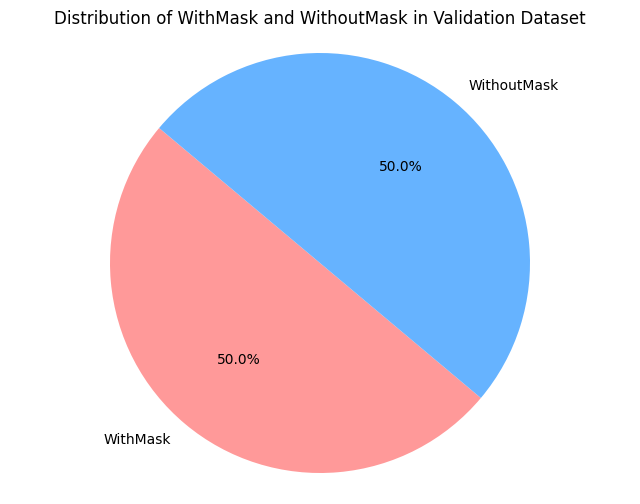

In [12]:
with_mask_dir = '/content/drive/MyDrive/Face Mask Dataset/Validation/WithMask'
without_mask_dir = '/content/drive/MyDrive/Face Mask Dataset/Validation/WithoutMask'

num_with_mask = len(os.listdir(with_mask_dir))
num_without_mask = len(os.listdir(without_mask_dir))

colors = ['#ff9999', '#66b3ff']

plt.figure(figsize=(8, 6), facecolor='white')
plt.pie([num_with_mask, num_without_mask], labels=['WithMask', 'WithoutMask'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of WithMask and WithoutMask in Validation Dataset')
plt.axis('equal')  

plt.show()

# DIY CNN

In [104]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5685, 0.4648, 0.4162], [0.2430, 0.2229, 0.2187])
])

train_set = datasets.ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Train', transform=transform)
test_set = datasets.ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Test', transform=transform)
val_set = datasets.ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Validation', transform=transform)

In [105]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)

In [106]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [59]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        # Fully connected layer
        self.fc = nn.Linear(32 * 28 * 28, 2)  # Assuming input image size is 224x224

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        # Flatten the output for fully connected layer
        x = x.view(-1, 32 * 28 * 28)
        # Dropout
        x = self.dropout(x)
        # Fully connected layer with softmax activation
        x = self.fc(x)
        return x

# Instantiate the model
model = MyCNN()

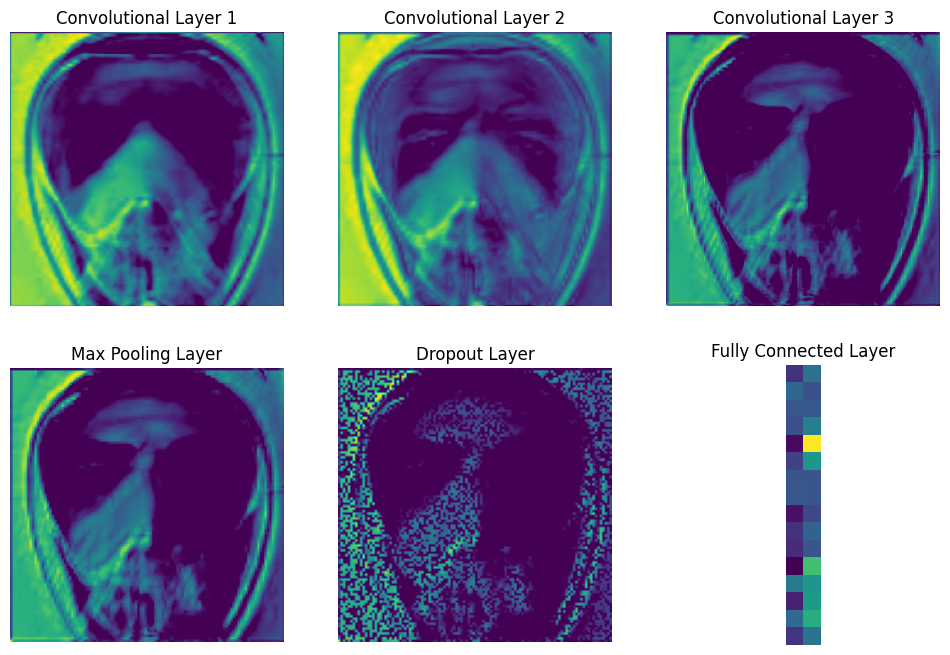

In [63]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 모델 생성
model = MyCNN()

# train_set에서 이미지 하나를 선택
image, label = train_set[0]

# 이미지를 모델에 전달하여 각 레이어의 출력 저장
x = image.unsqueeze(0)  # 배치 차원 추가
conv1_output = F.relu(model.conv1(x))
conv2_output = F.relu(model.conv2(conv1_output))
conv3_output = F.relu(model.conv3(conv2_output))
pool_output = model.pool(conv3_output)
dropout_output = model.dropout(pool_output)
flatten_output = dropout_output.view(-1, 32 * 28 * 28)
fc_output = model.fc(flatten_output)

# 피쳐 맵 시각화
plt.figure(figsize=(12, 8))

# Convolutional Layer 1
plt.subplot(2, 3, 1)
plt.imshow(conv1_output[0, 0].detach().numpy(), cmap='viridis')
plt.title('Convolutional Layer 1')
plt.axis('off')

# Convolutional Layer 2
plt.subplot(2, 3, 2)
plt.imshow(conv2_output[0, 0].detach().numpy(), cmap='viridis')
plt.title('Convolutional Layer 2')
plt.axis('off')

# Convolutional Layer 3
plt.subplot(2, 3, 3)
plt.imshow(conv3_output[0, 0].detach().numpy(), cmap='viridis')
plt.title('Convolutional Layer 3')
plt.axis('off')

# Max Pooling Layer
plt.subplot(2, 3, 4)
plt.imshow(pool_output[0, 0].detach().numpy(), cmap='viridis')
plt.title('Max Pooling Layer')
plt.axis('off')

# Dropout Layer
plt.subplot(2, 3, 5)
plt.imshow(dropout_output[0, 0].detach().numpy(), cmap='viridis')
plt.title('Dropout Layer')
plt.axis('off')

# Fully Connected Layer
plt.subplot(2, 3, 6)
plt.imshow(fc_output.detach().numpy(), cmap='viridis')
plt.title('Fully Connected Layer')
plt.axis('off')

plt.show()

In [65]:
print(model)

MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=25088, out_features=2, bias=True)
)


In [66]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [67]:
# 손실과 정확도를 저장하기 위한 리스트
train_losses = []
test_losses = []
val_losses = []
train_accuracies = []
test_accuracies = []
val_accuracies = []

In [68]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}')

In [69]:
# 검증 함수
def val(model, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader)
    accuracy = 100. * correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)
    print(f'val loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [70]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [71]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    val(model, val_loader)

# 정확도가 오히려 떨어진다. 버리자.

Epoch 1, Training loss: 0.4130
val loss: 0.0611, Accuracy: 97.75%
Epoch 2, Training loss: 0.1028
val loss: 0.0507, Accuracy: 98.00%
Epoch 3, Training loss: 0.1094
val loss: 0.0730, Accuracy: 97.75%
Epoch 4, Training loss: 0.1081
val loss: 0.1591, Accuracy: 93.38%


KeyboardInterrupt: 

# Resnet18

In [72]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5685, 0.4648, 0.4162], [0.2430, 0.2229, 0.2187])
])

train_set = datasets.ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Train', transform=transform)
test_set = datasets.ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Test', transform=transform)
val_set = datasets.ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Validation', transform=transform)

In [73]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)

In [74]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [75]:
class myResNet(nn.Module):
    def __init__(self):
        super(myResNet, self).__init__()
        self.resnet = models.resnet18(weights=None)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        return self.resnet(x)

In [76]:
model = myResNet().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01)
# optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

In [77]:
train_losses = []
test_losses = []
val_losses = []
train_accuracies = []
test_accuracies = []
val_accuracies = []

In [78]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}')
    accuracy = 100. * correct / total
    train_accuracies.append(accuracy)

In [79]:
def val(model, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader)
    accuracy = 100. * correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)
    print(f'val loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

optimizer = Adam

In [80]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    val(model, val_loader)

Epoch 1, Training loss: 0.2917
val loss: 0.1073, Accuracy: 97.00%
Epoch 2, Training loss: 0.1398
val loss: 0.0731, Accuracy: 98.25%
Epoch 3, Training loss: 0.0960
val loss: 0.0747, Accuracy: 98.00%
Epoch 4, Training loss: 0.0732
val loss: 0.0868, Accuracy: 97.62%
Epoch 5, Training loss: 0.0677
val loss: 0.0577, Accuracy: 98.00%
Epoch 6, Training loss: 0.0589
val loss: 0.0847, Accuracy: 97.00%
Epoch 7, Training loss: 0.0545
val loss: 0.0382, Accuracy: 98.62%
Epoch 8, Training loss: 0.0476
val loss: 0.0489, Accuracy: 98.12%
Epoch 9, Training loss: 0.0395
val loss: 0.0935, Accuracy: 96.50%
Epoch 10, Training loss: 0.0422
val loss: 0.0394, Accuracy: 98.62%


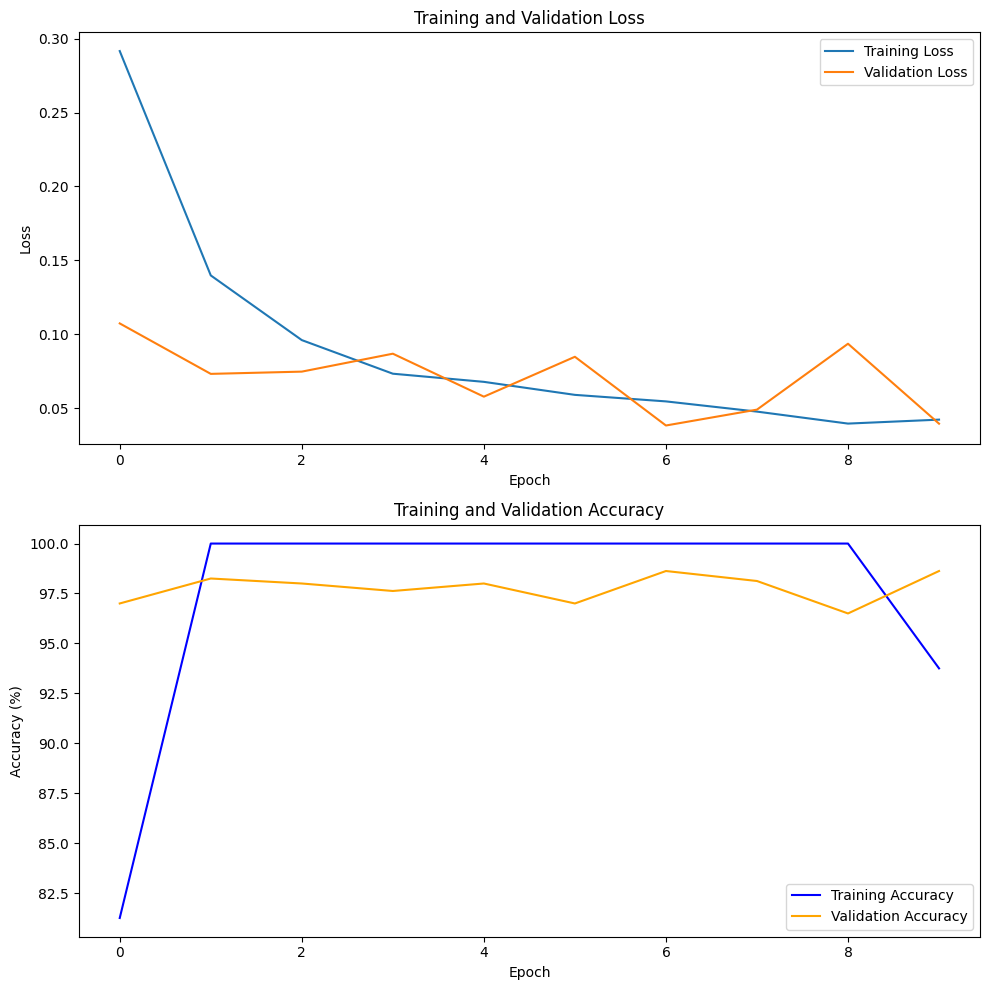

In [81]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(val_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Validation Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(val_accuracies, label='Validation Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [82]:
def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_accuracy = correct / total
    test_loss /= len(test_loader)

    return test_loss, test_accuracy

test_loss, test_accuracy = evaluate(model, test_loader, criterion)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.050935367470130236
Test Accuracy: 0.9828629032258065


optimizer = SGD

In [ ]:
# 훈련 및 테스트 실행
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    val(model, val_loader)

Epoch 1, Training loss: 0.2307
val loss: 0.3463, Accuracy: 90.00%
Epoch 2, Training loss: 0.0902
val loss: 0.0427, Accuracy: 98.38%
Epoch 3, Training loss: 0.0524
val loss: 0.0521, Accuracy: 98.00%
Epoch 4, Training loss: 0.0375
val loss: 0.0856, Accuracy: 97.12%
Epoch 5, Training loss: 0.0325
val loss: 0.0405, Accuracy: 98.88%
Epoch 6, Training loss: 0.0199
val loss: 0.0374, Accuracy: 98.62%
Epoch 7, Training loss: 0.0180
val loss: 0.0244, Accuracy: 98.88%
Epoch 8, Training loss: 0.0076
val loss: 0.0072, Accuracy: 99.88%
Epoch 9, Training loss: 0.0116
val loss: 0.0087, Accuracy: 99.50%
Epoch 10, Training loss: 0.0093
val loss: 0.0049, Accuracy: 99.75%


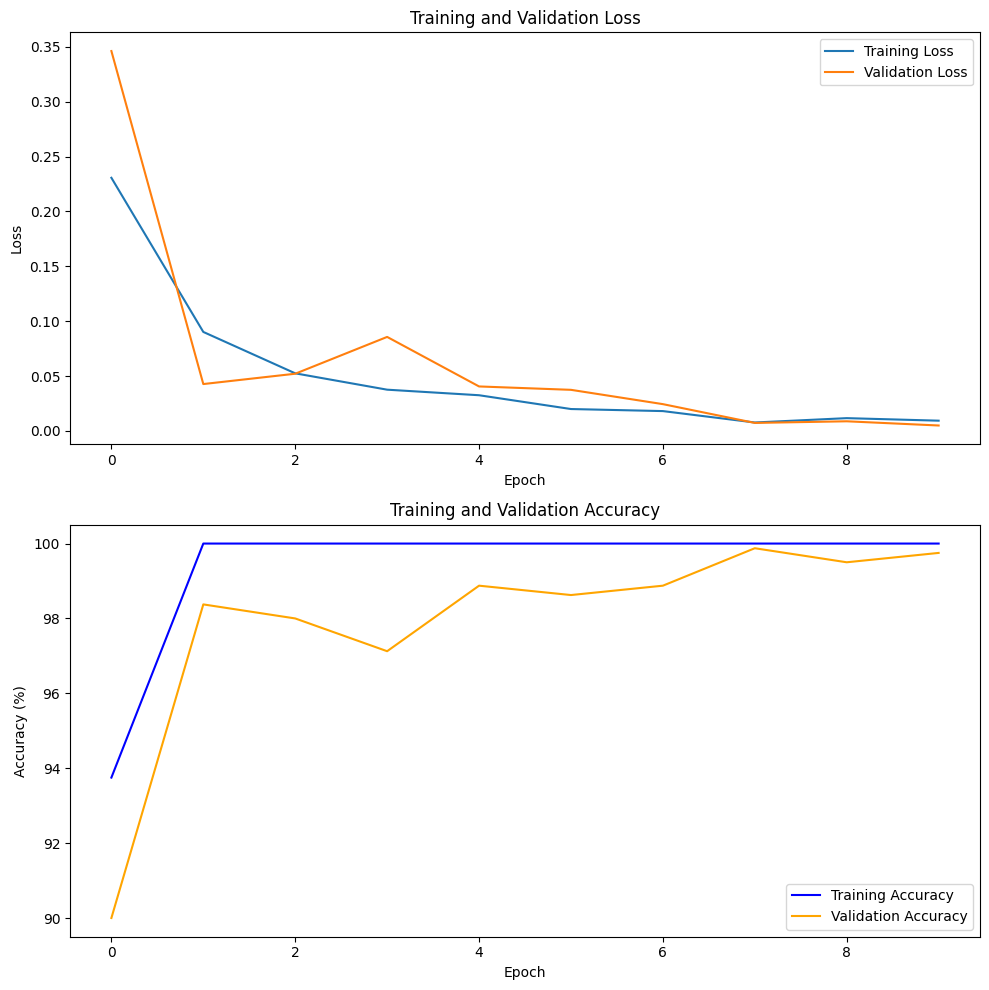

In [ ]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(val_losses, label='Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Validation Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(val_accuracies, label='Validation Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
# evaluate 함수 정의
def evaluate(model, test_loader, criterion):
    model.eval()  # 모델을 평가(테스트) 모드로 설정
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # 그라디언트 계산 비활성화
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    # 정확도 계산
    test_accuracy = correct / total
    test_loss /= len(test_loader)

    return test_loss, test_accuracy

# 모델 평가
test_loss, test_accuracy = evaluate(model, test_loader, criterion)

# 테스트 손실과 정확도 출력
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.008722839585032253
Test Accuracy: 0.9969758064516129


# VGG16

In [83]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5685, 0.4648, 0.4162], [0.2430, 0.2229, 0.2187])
])

train_set = datasets.ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Train', transform=transform)
test_set = datasets.ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Test', transform=transform)
val_set = datasets.ImageFolder('/content/drive/MyDrive/Face Mask Dataset/Validation', transform=transform)

In [84]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)

In [85]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [86]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.vgg16 = models.vgg16(pretrained=True)
        self.vgg16.classifier[-1] = nn.Linear(4096, 2) 

    def forward(self, x):
        return self.vgg16(x)

model = VGG16()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 92.1MB/s]


In [87]:
model = VGG16().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [88]:
train_losses = []
test_losses = []
val_losses = []
train_accuracies = []
test_accuracies = []
val_accuracies = []

In [89]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, target in train_loader:
        if torch.cuda.is_available():
            data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch}, Training loss: {train_loss:.4f}')
    accuracy = 100. * correct / total
    train_accuracies.append(accuracy) 

In [90]:
def val(model, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader)
    accuracy = 100. * correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(accuracy)
    print(f'val loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [91]:
for epoch in range(1, 11):
    train(model, train_loader, optimizer, epoch)
    val(model, val_loader)

# 버리자.

Epoch 1, Training loss: 871142677.6560
val loss: 0.6933, Accuracy: 50.00%
Epoch 2, Training loss: 0.6998
val loss: 0.6936, Accuracy: 50.00%
Epoch 3, Training loss: 0.6969
val loss: 0.6933, Accuracy: 50.00%
Epoch 4, Training loss: 0.6954
val loss: 0.6932, Accuracy: 50.00%
Epoch 5, Training loss: 0.6942
val loss: 0.6933, Accuracy: 50.00%


KeyboardInterrupt: 